In [6]:
import argparse
import torch
import datetime
import json
import yaml
import os
import numpy as np
from dataset_pm25 import get_dataloader
from main_model import CSDI_PM25
from utils import train, evaluate
import matplotlib.pyplot as plt

In [14]:
np.random.seed(123)
torch.manual_seed(0)

# generate simu data for fast test

N = 100 # len of total T 
train_ratio = 0.1 # ratio of test data
self_mask_ratio = 0.5 # ratio of masked for self-supervissed training

N_f = 8 # number of vars

func_base = [np.sin,np.cos,lambda x:0.1 * x,lambda x:-0.1 * x]

func_list = [np.sin, np.cos,\
     lambda x:np.sin(x)*np.sin(x), lambda x:np.sin(x)*np.sin(x)*np.cos(x),
     lambda x:np.cos(x)*np.sin(x) + 0.1*x, lambda x:np.sin(x)*np.sin(x)*np.sin(x) - 0.1*x,
     lambda x:np.cos(x)*np.cos(x)*np.exp(-0.2*x) - 0.2*x,lambda x:np.cos(x)*np.cos(x)*np.sin(x)*np.exp(0.4*x)+0.2*x]


# generate data
T_array = np.sort(np.random.rand(N))*2*np.pi 

data_all = np.stack([func(T_array) + np.random.randn(N) * 0.2 for func in func_list])
data_all.shape

(8, 100)

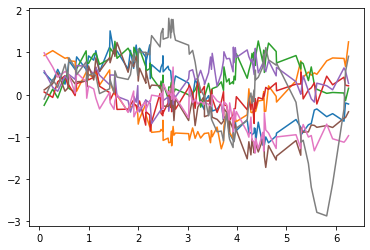

In [13]:
plt.plot(T_array,data_all.T)

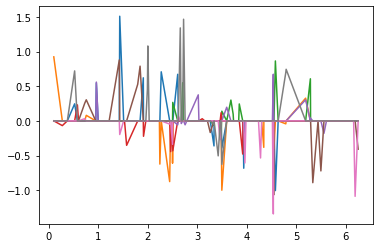

In [15]:
# generate mask 
N_train = int(N * train_ratio) # 1-train, 0-test
N_condi = int(N_train * self_mask_ratio)# 1-conditional in train, 0-target in train

mask_train_list = []
mask_condi_list = []
mask_target_list = []

for i in range(N_f):
    mask_train = np.zeros(N)
    mask_condi = np.zeros(N)
    mask_target = np.zeros(N)

    mask_train_ind = np.random.choice(N, N_train, replace=False)
    mask_condi_ind = mask_train_ind[:N_condi]
    mask_target_ind = mask_train_ind[N_condi:]

    mask_train[mask_train_ind] = 1
    mask_condi[mask_condi_ind] = 1
    mask_target[mask_target_ind] = 1


    mask_train_list.append(mask_train)
    mask_condi_list.append(mask_condi)
    mask_target_list.append(mask_target)

mask_train = np.stack(mask_train_list).astype(np.bool_)
mask_condi = np.stack(mask_condi_list).astype(np.bool_)    
mask_target = np.stack(mask_target_list).astype(np.bool_) 
plt.plot(T_array,(data_all*mask_train).T)


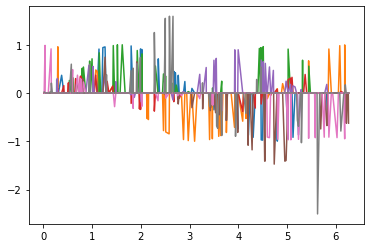

In [5]:
plt.plot(T_array,(data_all*mask_condi).T)

In [16]:
simu_data = {
    'data_all':data_all,# time series
    'time_step':T_array,# Time step
    'mask_train':mask_train, 
    'mask_condi':mask_condi,
    'mask_target':mask_target,
}
np.save('./data/simu/simu_data_noise.npy', simu_data)